In [197]:
import json
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

#### Import data and chcek them out

In [198]:
data_fea = pd.read_csv('takehome_users.csv',encoding='ISO-8859-1')

data_vis = pd.read_csv('takehome_user_engagement.csv')

In [199]:
data_fea.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [200]:
data_fea.drop(columns=['creation_time','name','email','last_session_creation_time','invited_by_user_id'],inplace=True)

In [201]:
data_fea.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id
0,1,GUEST_INVITE,1,0,11
1,2,ORG_INVITE,0,0,1
2,3,ORG_INVITE,0,0,94
3,4,GUEST_INVITE,0,0,1
4,5,GUEST_INVITE,0,0,193


In [202]:
data_fea.shape

(12000, 5)

#### Clean data

In [203]:
data_vis.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [204]:
data_vis.drop(columns=['time_stamp'],inplace=True)

In [205]:
data_vis.head()

,user_id,visited
0,1,1
1,2,1
2,2,1
3,2,1
4,2,1


In [206]:
data_vis_new = data_vis.groupby('user_id').sum()

In [207]:
data_vis_new = pd.DataFrame(data_vis_new)

In [208]:
data_vis_new.reset_index(inplace=True)

In [209]:
data_vis_new.head()

,user_id,visited
0,1,1
1,2,14
2,3,1
3,4,1
4,5,1


In [210]:
data_vis_new.rename(columns={"user_id":"object_id"}, inplace=True)

In [211]:
data_vis_new.head()

,object_id,visited
0,1,1
1,2,14
2,3,1
3,4,1
4,5,1


In [212]:
data_vis_new.dtypes

object_id    int64
visited      int64
dtype: object

In [213]:
data_fea.dtypes

object_id                      int64
creation_source               object
opted_in_to_mailing_list       int64
enabled_for_marketing_drip     int64
org_id                         int64
dtype: object

In [214]:
df = data_fea.merge(data_vis_new, on ='object_id', how='inner')

In [215]:
df.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,visited
0,1,GUEST_INVITE,1,0,11,1
1,2,ORG_INVITE,0,0,1,14
2,3,ORG_INVITE,0,0,94,1
3,4,GUEST_INVITE,0,0,1,1
4,5,GUEST_INVITE,0,0,193,1


In [216]:

adop = []

for num in df['visited']:
    
    if num >= 3:
        
        adop.append(1)
    else:
        adop.append(0)

            

In [217]:
df['adop'] = adop

In [218]:
df.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,visited,adop
0,1,GUEST_INVITE,1,0,11,1,0
1,2,ORG_INVITE,0,0,1,14,1
2,3,ORG_INVITE,0,0,94,1,0
3,4,GUEST_INVITE,0,0,1,1,0
4,5,GUEST_INVITE,0,0,193,1,0


In [219]:
df.isnull().sum()

object_id                     0
creation_source               0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
visited                       0
adop                          0
dtype: int64

In [220]:
df.shape

(8823, 7)

In [221]:
df.dtypes

object_id                      int64
creation_source               object
opted_in_to_mailing_list       int64
enabled_for_marketing_drip     int64
org_id                         int64
visited                        int64
adop                           int64
dtype: object

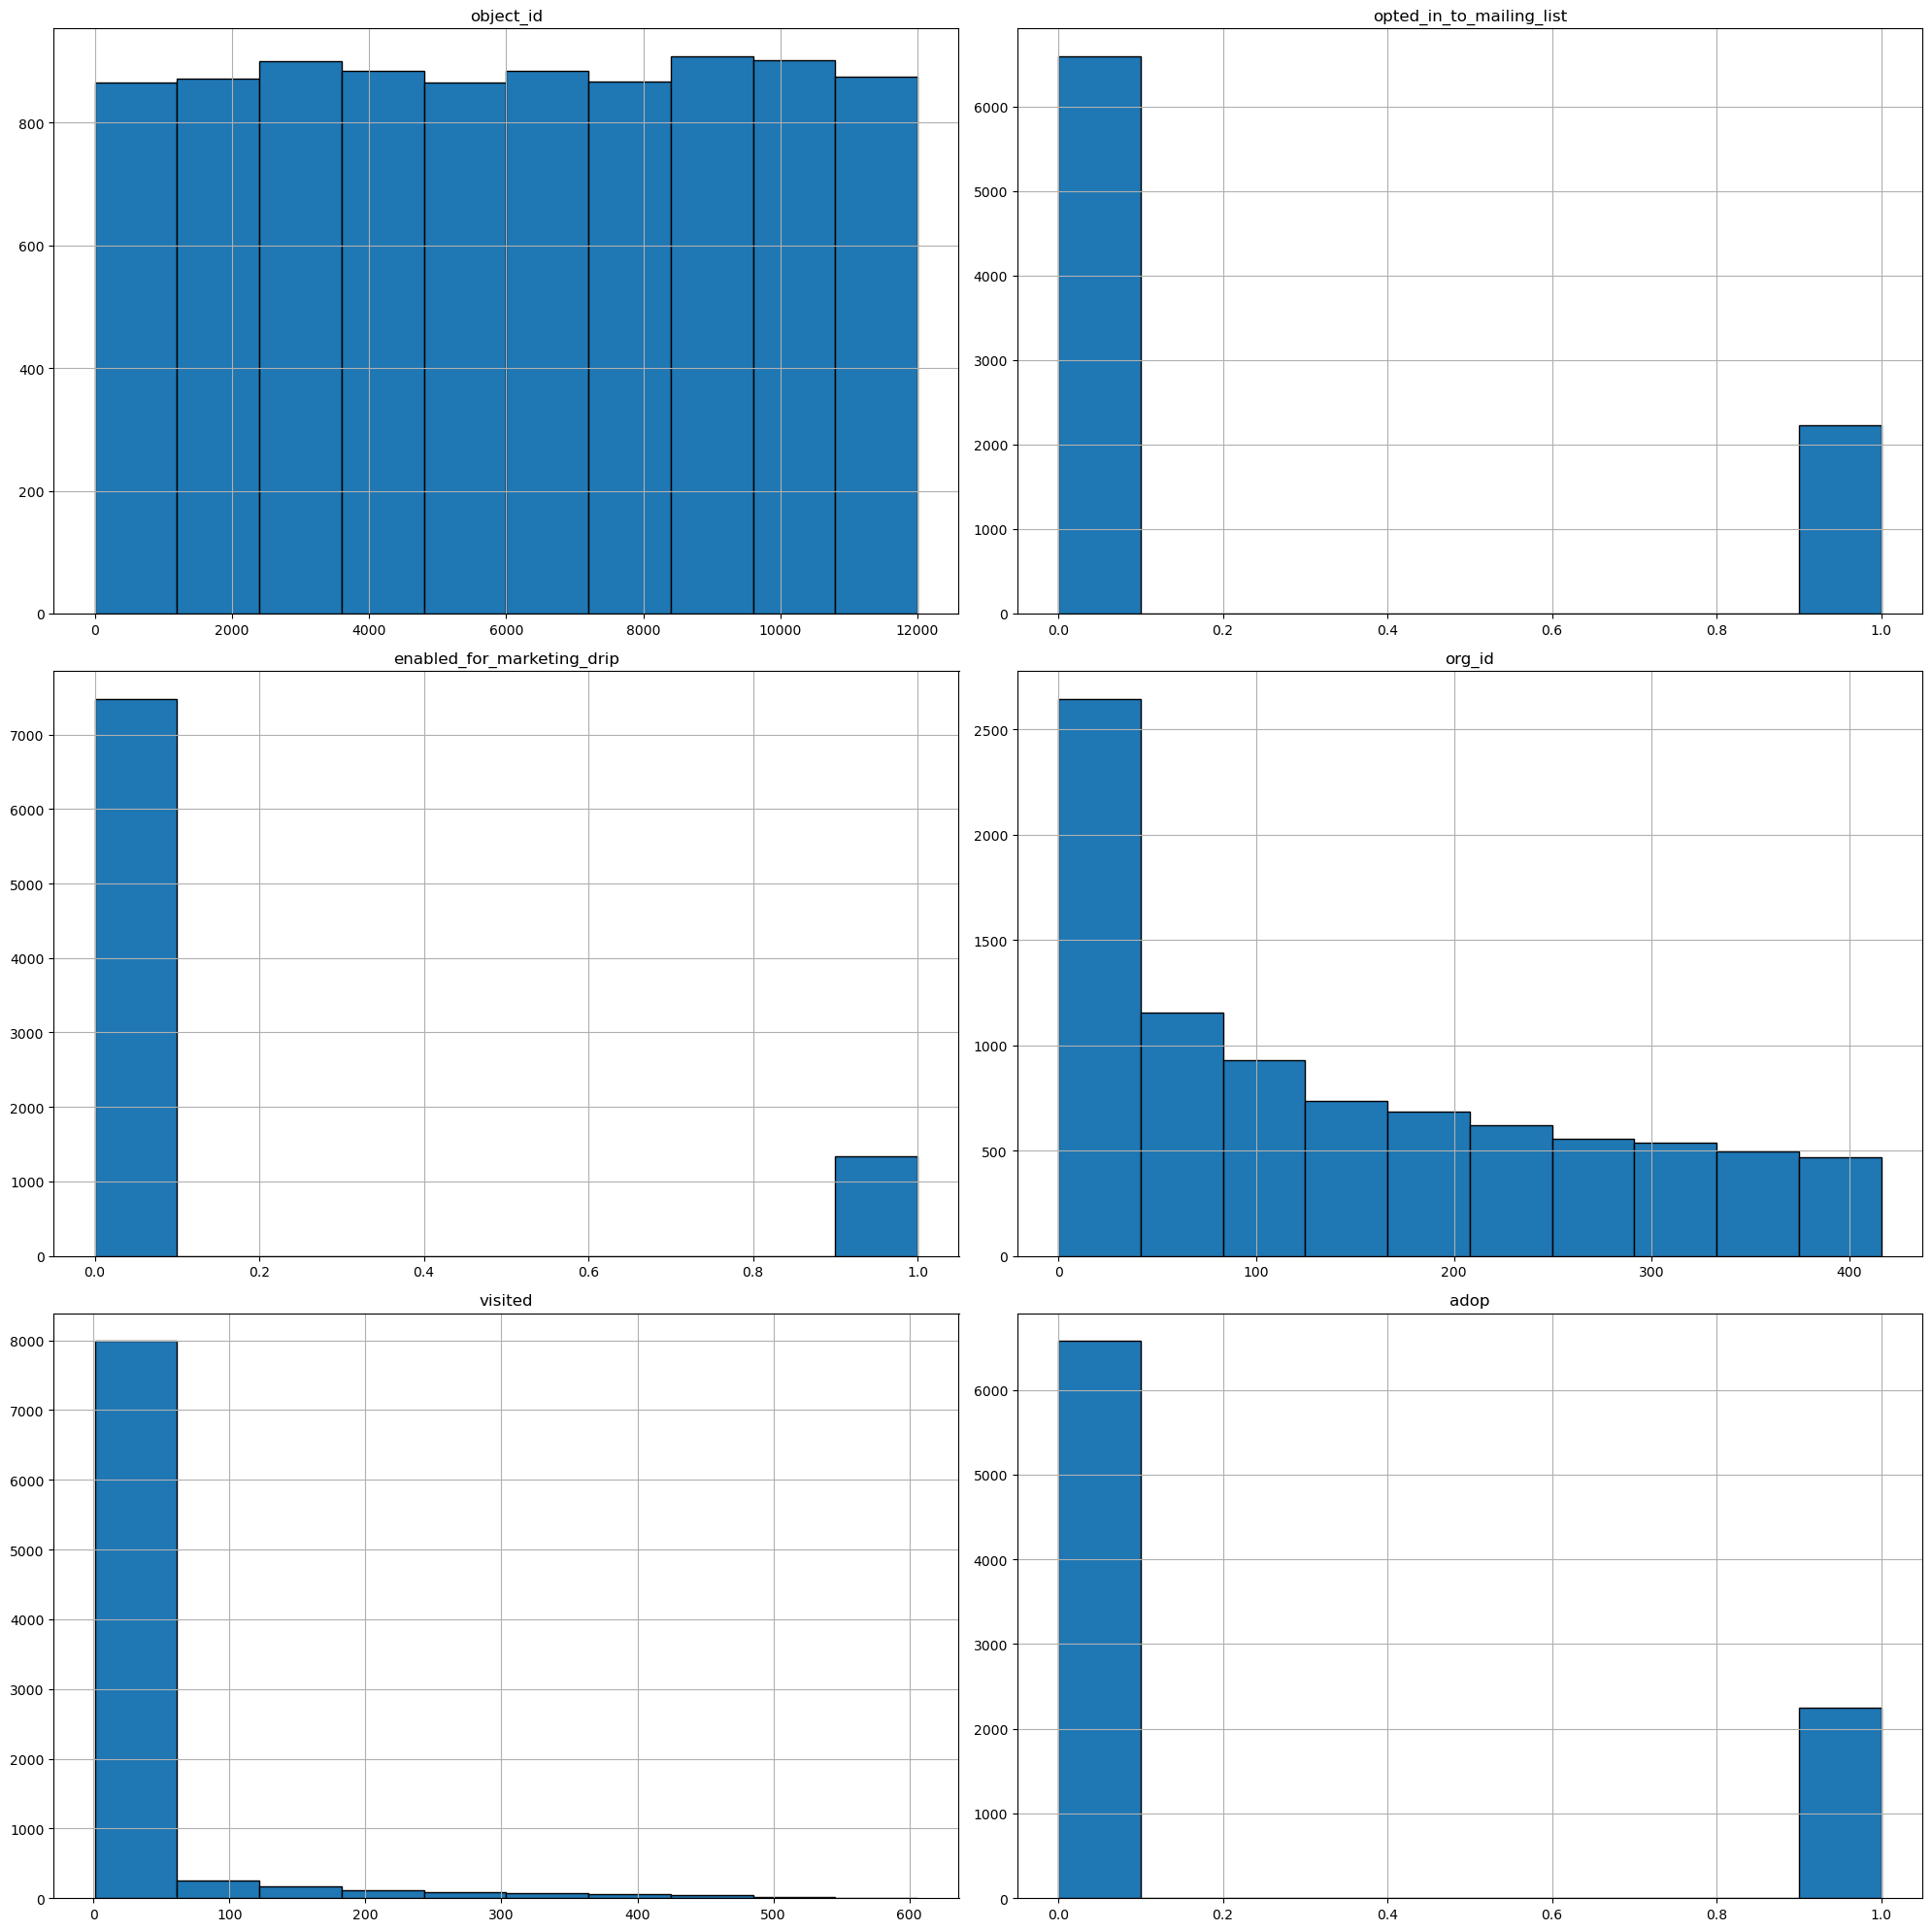

In [222]:
df.hist(figsize=(20,20),ec="k")
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()

#### Model

In [223]:
X = df.drop(columns = ['object_id','visited', 'adop'])
y = df['adop']

In [224]:
X.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id
0,GUEST_INVITE,1,0,11
1,ORG_INVITE,0,0,1
2,ORG_INVITE,0,0,94
3,GUEST_INVITE,0,0,1
4,GUEST_INVITE,0,0,193


In [225]:
X = pd.get_dummies(X, dtype=float)

In [226]:
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,1.0,0.0,0.0,0.0,0.0
1,0,0,1,0.0,1.0,0.0,0.0,0.0
2,0,0,94,0.0,1.0,0.0,0.0,0.0
3,0,0,1,1.0,0.0,0.0,0.0,0.0
4,0,0,193,1.0,0.0,0.0,0.0,0.0


In [227]:

X_train, X_test, y_train, y_test = train_test_split(X.copy(),y.copy(),shuffle=True,random_state=153,stratify = y, test_size=.2)



In [228]:
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 582)

In [229]:
y_train = y_train.to_numpy()

In [230]:
X_train = X_train.to_numpy()

In [231]:
j = 0
precision_mat = np.zeros((1,5))
recall_mat = np.zeros((1,5))
accuracy_mat = np.zeros((1,5))

for train_index, test_index in kfold.split(X_train, y_train):
    #print(train_index)
    ### Training
    X_train_train = X_train[train_index,:]
    y_train_train = y_train[train_index]
    
    ### Holdout set
    X_holdout = X_train[test_index,:]
    y_holdout = y_train[test_index]
       
    
    rm = RandomForestClassifier(n_estimators = 100)
    
    
    rm.fit(X_train_train,
            y_train_train)
    
    y_preds = rm.predict(X_holdout)
   
    
    precision_mat[0,j] = precision_score(y_holdout, y_preds,average="binary", pos_label=1)
    recall_mat[0,j] = recall_score(y_holdout, y_preds,average="binary", pos_label=1)
    accuracy_mat[0,j] = accuracy_score(y_holdout, y_preds)
    
    
    
    j += 1

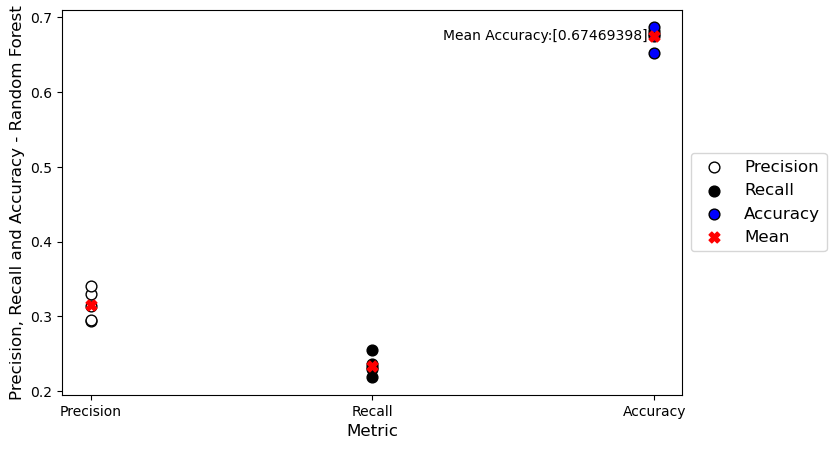

In [232]:
plt.figure(figsize=(8,5))
plt.scatter(np.zeros(5), 
            precision_mat[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Precision")
plt.scatter(np.ones(5), 
            recall_mat[0,:], 
            s=60, 
            c='black',
            edgecolor='black',label ="Recall")

plt.scatter(np.ones(5)*2, 
            accuracy_mat[0,:], 
            s=60, 
            c='blue',
            edgecolor='black',label ="Accuracy")

plt.scatter([0,1,2], 
            [np.mean(precision_mat, axis=1),np.mean(recall_mat, axis=1),np.mean(accuracy_mat, axis=1)], 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

# plt.annotate(f'Mean Precision:{np.mean(precision_mat, axis=1)}', xy=(0,0.67))
# plt.annotate(f'Mean Recall:{np.mean(recall_mat, axis=1)}', xy=(0.2,0.85))
plt.annotate(f'Mean Accuracy:{np.mean(accuracy_mat, axis=1)}', xy=(1.25,0.67))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)

plt.xticks([0,1,2],["Precision", "Recall","Accuracy"], fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Metric", fontsize=12)
plt.ylabel("Precision, Recall and Accuracy - Random Forest", fontsize=12)

plt.show()

#### Not the best results - would benefit from hyperparameter tuning.

### Use the model on the test set

In [236]:
rm = RandomForestClassifier(n_estimators = 100)
    
    
rm.fit(X_train,
            y_train)
    
y_preds = rm.predict(X_test)

C:\Users\Nadun\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [237]:
precision = precision_score(y_test, y_preds,average="binary", pos_label= 1)
recall = recall_score(y_test, y_preds,average="binary", pos_label= 1)
accuracy = accuracy_score(y_test, y_preds)
print('Accuracy',accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy 0.6623229461756374
Precision: 0.2983425414364641
Recall: 0.24


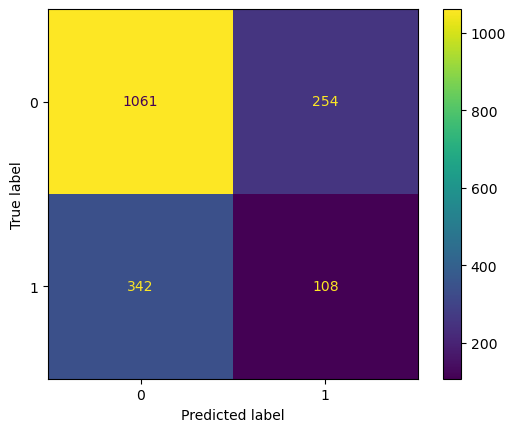

In [238]:
cm_new = confusion_matrix(y_test, y_preds)

ConfusionMatrixDisplay(confusion_matrix=cm_new).plot();

The model doesn't do well with labeling True values. I think hyperparameter tuning and more feature engineering would help.